## Explore the model


In [1]:
from student_sim.sim_factory import create_simulation
from student_sim.Graf import plot_simulation

### kjører først 1000 simulasjoner med 50% sjanse for at Alex går inn når hun ankommer Kaia eller Pentagon

{'total_students': 1000, 'finished': 1000, 'destinations': {'Pentagon': 500, 'Kaia': 500}, 'avg_steps': 1623.598, 'avg_time': 8111.69}


C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=endpoint_counts.index, y=endpoint_counts.values, palette='pastel')


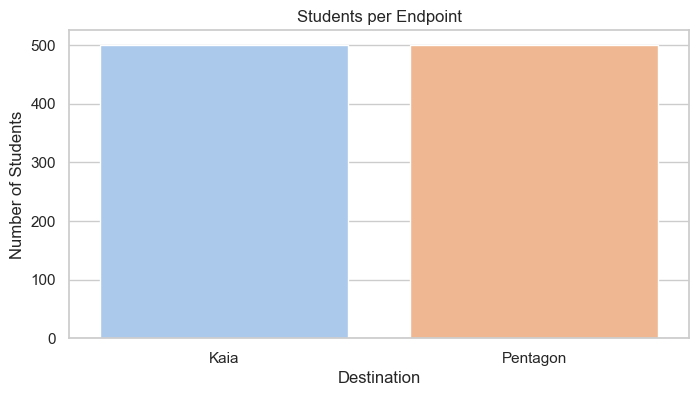

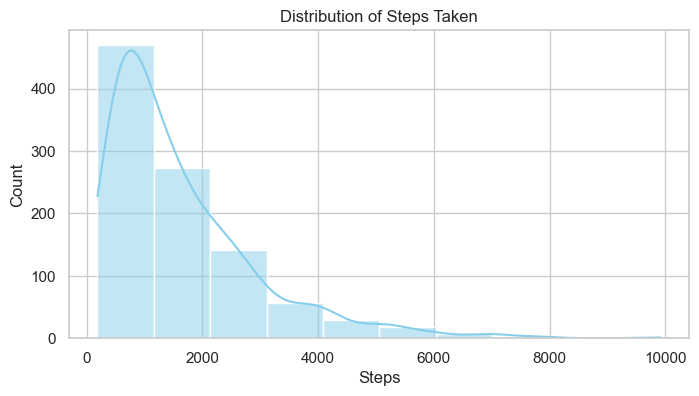

In [2]:
world, sim = create_simulation(n_students=1000, endpoints= [{"name": "Pentagon", "position": 90, "entry_prob": 0.5, "max_capacity": 0},
                                                           {"name": "Kaia", "position": 10, "entry_prob": 0.5, "max_capacity": 0}])
create_simulation()
sim.run()
print(sim.get_stats())
plot_simulation(world, sim)

### Alex fordeler seg ca 50-50 mellom Pentagon og Kaja, og bruker ca 1600 steg i snitt

### Øker entry-sjansen for Pentagon til 70% og justerer Kaja sin ned til 30%

{'total_students': 1000, 'finished': 1000, 'destinations': {'Pentagon': 522, 'Kaia': 478}, 'avg_steps': 1666.533, 'avg_time': 8333.683}


C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=endpoint_counts.index, y=endpoint_counts.values, palette='pastel')


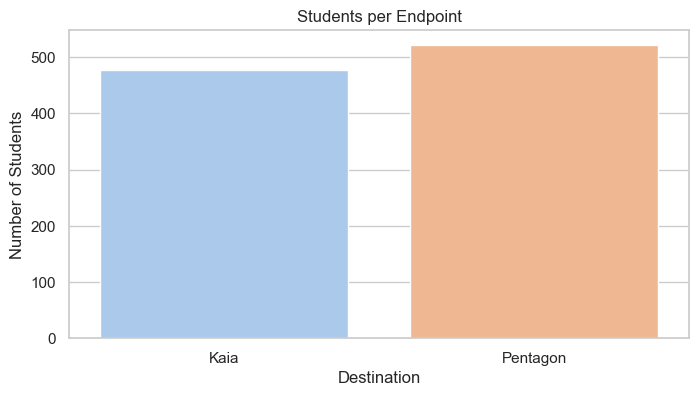

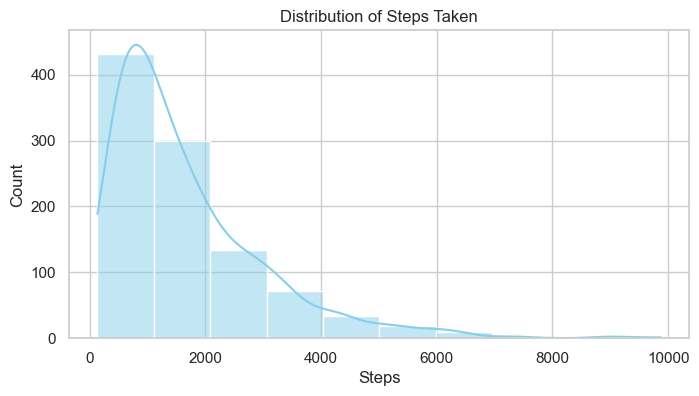

In [ ]:
world, sim = create_simulation(n_students=1000, endpoints= [{"name": "Pentagon", "position": 90, "entry_prob": 0.7, "max_capacity": 0},
                                                           {"name": "Kaia", "position": 10, "entry_prob": 0.3, "max_capacity": 0}])
create_simulation()
sim.run()
print(sim.get_stats())
plot_simulation(world, sim)

### Fordelingen heller litt mer mot Pentagon enn Kaja, men ikke like mye som forventet. Dette kommer sansynligvis av at studentene vil fordele seg til øst og vest, og at studentene som ikke kommer seg inn i Kaja vi holde seg rundt Kaja, og bare bruke lengre tid på å komme seg inn istedenfor å bevege seg til Pentagon istedet.

{'total_students': 1000, 'finished': 1000, 'destinations': {'Pentagon': 544, 'Kaia': 456}, 'avg_steps': 2123.27, 'avg_time': 10617.336}


C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=endpoint_counts.index, y=endpoint_counts.values, palette='pastel')


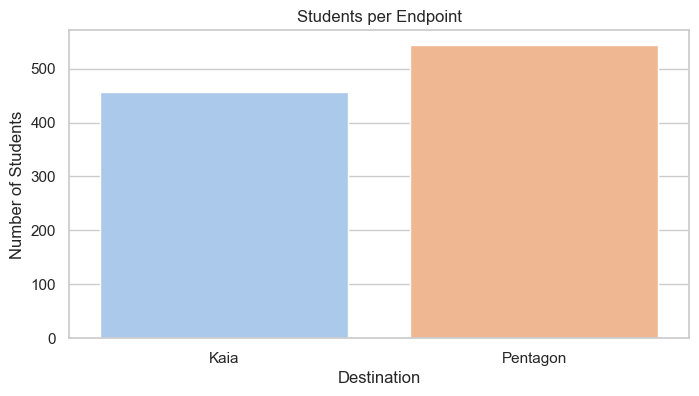

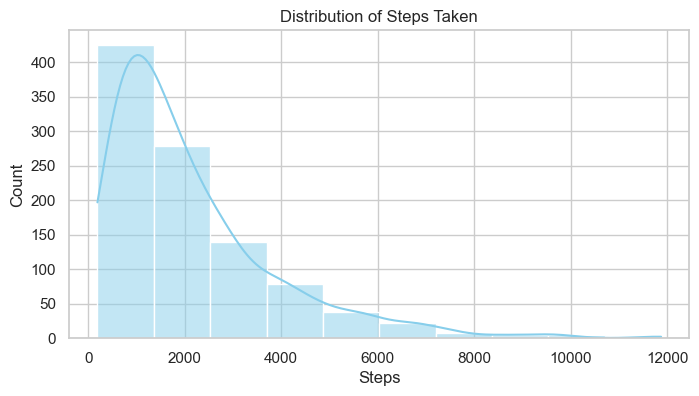

In [ ]:
world, sim = create_simulation(n_students=1000, endpoints= [{"name": "Pentagon", "position": 90, "entry_prob": 0.99, "max_capacity": 0},
                                                           {"name": "Kaia", "position": 10, "entry_prob": 0.01, "max_capacity": 0}])
create_simulation()
sim.run()
print(sim.get_stats())
plot_simulation(world, sim)

### Dette støttes viderer når entry_prob settes til hhv. 99% og 1% For Pentagon og Kaja, men her ser man at gjennomsnittlig antall steg øker til 2100

### Prøver å endre på sjansen for hvilken retning Alex beveger seg

{'total_students': 1000, 'finished': 1000, 'destinations': {'Pentagon': 819, 'Kaia': 181}, 'avg_steps': 1328.511, 'avg_time': 6643.318}


C:\Users\brage\Anvendt_Robotikk\INF201\Deliverables\d4_Brage_Gabriel\src\student_sim\Graf.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=endpoint_counts.index, y=endpoint_counts.values, palette='pastel')


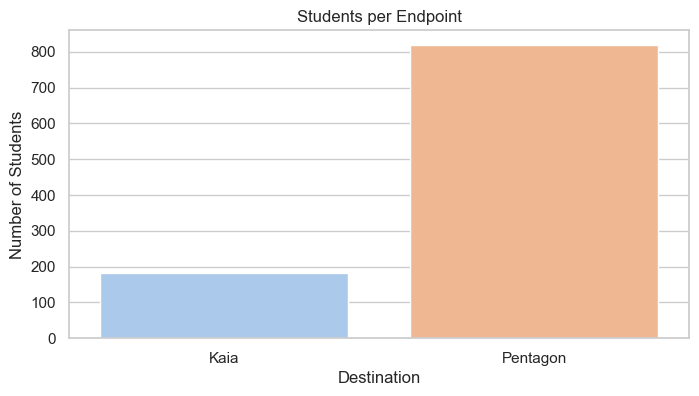

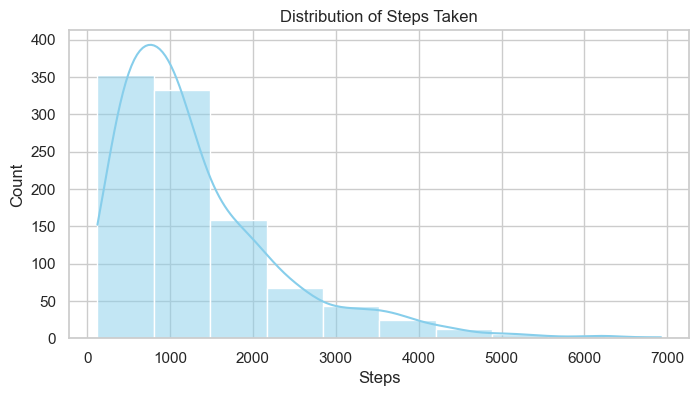

In [ ]:
world, sim = create_simulation(n_students=1000, move_east_prob= 0.51, endpoints= [{"name": "Pentagon", "position": 90, "entry_prob": 0.5, "max_capacity": 0},
                                                           {"name": "Kaia", "position": 10, "entry_prob": 0.5, "max_capacity": 0}])
create_simulation()
sim.run()
print(sim.get_stats())
plot_simulation(world, sim)

### Dette har store konsekvenser! Bare 1% større sjanse for å gå østover fører til at 80% av studentene endte ved Pentagon